# [Scene Recognition with Bag-of-Words](https://www.cc.gatech.edu/~hays/compvision/proj4/)
For this project, you will need to report performance for three
combinations of features / classifiers. It is suggested you code them in
this order, as well:
1. Tiny image features and nearest neighbor classifier
2. Bag of sift features and nearest neighbor classifier
3. Bag of sift features and linear SVM classifier

The starter code is initialized to 'placeholder' just so that the starter
code does not crash when run unmodified and you can get a preview of how
results are presented.

## Setup

In [42]:
import wandb
# Set up parameters, image paths and category list
# %matplotlib notebook
%load_ext autoreload
%autoreload 2
print("a")


import cv2
import numpy as np
import os.path as osp
import pickle
from random import shuffle
import matplotlib.pyplot as plt
from utils import *
import student_code_12012530 as sc

# 这个作业主要就是实现几个方法，然后在这个小数据集上面测试

# This is the list of categories / directories to use. The categories are
# somewhat sorted by similarity so that the confusion matrix looks more
# structured (indoor and then urban and then rural).
categories = ['Kitchen', 'Store', 'Bedroom', 'LivingRoom', 'Office', 'Industrial', 'Suburb',
              'InsideCity', 'TallBuilding', 'Street', 'Highway', 'OpenCountry', 'Coast',
              'Mountain', 'Forest'];
# This list of shortened category names is used later for visualization
abbr_categories = ['Kit', 'Sto', 'Bed', 'Liv', 'Off', 'Ind', 'Sub',
                   'Cty', 'Bld', 'St', 'HW', 'OC', 'Cst',
                   'Mnt', 'For'];

# Number of training examples per category to use. Max is 100. For
# simplicity, we assume this is the number of test cases per category, as
# well.
num_train_per_cat = 100

# This function returns lists containing the file path for each train
# and test image, as well as lists with the label of each train and
# test image. By default all four of these lists will have 1500 elements
# where each element is a string.
data_path = osp.join('..', 'data')
print("over")
train_image_paths, test_image_paths, train_labels, test_labels = get_image_paths(data_path,
                                                                                 categories,
                                                                                 num_train_per_cat);



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
a
over


In [43]:

config = dict (
    k_knn = -1,
    metric_knn='euclidean',
    regular_parameter_svm = 5.0,
    loss_svm = 'hinge',
    penalty_svm = 'l2',
    dsift_step = 9,
    dsift_size = 5,
    vocab_size = 100,
    number_of_patch = 5,
)

wandb.init(
    project="cv_hw3",
    notes="finetune_step_size",
    #   tags=["baseline", "paper1"],
    config=config,
    name = "finetune_step_size7"  # 这个参数最关键
)

## Section 1: Tiny Image features with Nearest Neighbor classifier

### Section 1a: Represent each image with the Tiny Image feature

Each function to construct features should return an N x d numpy array, where N is the number of paths passed to the function and d is the dimensionality of each image representation. See the starter code for each function for more details.

In [44]:
print('Using the TINY IMAGE representation for images')

train_image_feats = sc.get_tiny_images(train_image_paths)
test_image_feats = sc.get_tiny_images(test_image_paths)

Using the TINY IMAGE representation for images
make feats numpy array
<class 'numpy.ndarray'>
make feats numpy array
<class 'numpy.ndarray'>


### Section 1b: Classify each test image by training and using the Nearest Neighbor classifier

Each function to classify test features will return an N element list, where N is the number of test cases and each entry is a string indicating the predicted category for each test image. Each entry in 'predicted_categories' must be one of the 15 strings in 'categories', 'train_labels', and 'test_labels'. See the starter code for each function for more details.

In [45]:
print('Using NEAREST NEIGHBOR classifier to predict test set categories')



def compute_acc(y_true, y_pred):
    from sklearn.metrics import confusion_matrix,accuracy_score
    acc = accuracy_score(y_true,y_pred)

    return acc

def K_cross_validation():
    train_labels_array = np.array(train_labels)
    from sklearn.model_selection import KFold
    the_best_k = -1
    the_max_acc = 0
    # train_image_feats_in, train_labels_array_in = shuffle(train_image_feats, train_labels_array)  # 这里不shuffle真的很离谱，输入数据全部是顺序
    for k_current in range(1,8):
        acc_list = []
        for rp in range(0,5):# 这个不稳定，多重复几次
            kf = KFold(n_splits=4,shuffle=True)

            for train_index, test_index in kf.split(train_image_feats):
                # print(train_image_feats[train_index])
                predicted_categories = sc.nearest_neighbor_classify(train_image_feats[train_index], train_labels_array[train_index], train_image_feats[test_index], metric=wandb.config.metric_knn, k=k_current)
                cur_acc = compute_acc(predicted_categories,train_labels_array[test_index])
                acc_list.append(cur_acc)
        mean_acc = np.mean(np.array(acc_list))
        if mean_acc > the_max_acc:
            the_max_acc = mean_acc
            the_best_k = k_current
    print(the_best_k)
    return the_best_k

predicted_categories = sc.nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats, metric=wandb.config.metric_knn, k=1)  # 这里不如面向数据集调参

Using NEAREST NEIGHBOR classifier to predict test set categories


### Section 1c: Build a confusion matrix and score the recognition system

(You do not need to code anything in this section.)

If we wanted to evaluate our recognition method properly we would train
and test on many random splits of the data. You are not required to do so
for this project.

This function will create a confusion matrix and various image
thumbnails each time it is called. View the confusion matrix to help interpret
your classifier performance. Where is it making mistakes? Are the
confusions reasonable?

Interpreting your performance with 100 training examples per category:
- accuracy  =   0 -> Your code is broken (probably not the classifier's fault! A classifier would have to be amazing to perform this badly).
- accuracy ~= .07 -> Your performance is chance. Something is broken or you ran the starter code unchanged.
- accuracy ~= .20 -> Rough performance with tiny images and nearest neighbor classifier. Performance goes up a few percentage points with K-NN instead of 1-NN.
- accuracy ~= .20 -> Rough performance with tiny images and linear SVM classifier. The linear classifiers will have a lot of trouble trying to separate the classes and may be unstable (e.g. everything classified to one category)
- accuracy ~= .50 -> Rough performance with bag of SIFT and nearest neighbor classifier. Can reach .60 with K-NN and different distance metrics.
- accuracy ~= .60 -> You've gotten things roughly correct with bag of SIFT and a linear SVM classifier.
- accuracy >= .70 -> You've also tuned your parameters well. E.g. number of clusters, SVM regularization, number of patches sampled when building vocabulary, size and step for dense SIFT features.
- accuracy >= .80 -> You've added in spatial information somehow or you've added additional, complementary image features. This represents state of the art in Lazebnik et al 2006.
- accuracy >= .85 -> You've done extremely well. This is the state of the art in the 2010 SUN database paper from fusing many  features. Don't trust this number unless you actually measure many random splits.
- accuracy >= .90 -> You used modern deep features trained on much larger image databases.
- accuracy >= .96 -> You can beat a human at this task. This isn't a realistic number. Some accuracy calculation is broken or your classifier is cheating and seeing the test labels.

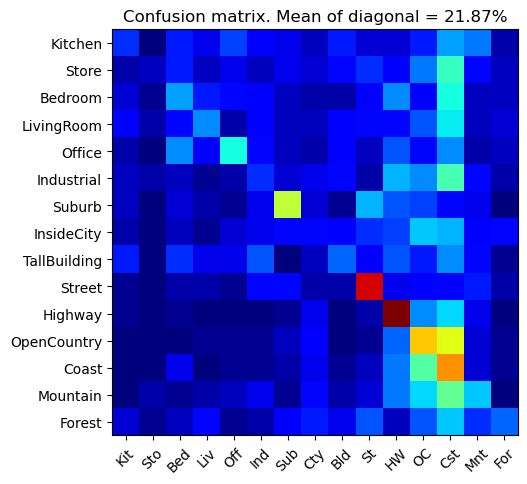

In [46]:
show_results(train_image_paths, test_image_paths, train_labels, test_labels, categories, abbr_categories,
             predicted_categories)


## Section 2: Bag of SIFT features with Nearest Neighbor classifier

### Section 2a: Represent each image with the Bag of SIFT feature

To create a new vocabulary, make sure `vocab_filename` is different than the old vocabulary, or delete the old one.

In [47]:
print('Using the BAG-OF-SIFT representation for images')

vocab_filename = 'vocab.pkl'
if not osp.isfile(vocab_filename):
    # Construct the vocabulary
    print('No existing visual word vocabulary found. Computing one from training images')
    # vocab_size = 200  # Larger values will work better (to a point) but be slower to compute
    vocab = sc.build_vocabulary(train_image_paths, wandb.config.vocab_size, dsift_step=wandb.config.dsift_step, dsift_size= wandb.config.dsift_step)
    with open(vocab_filename, 'wb') as f:
        pickle.dump(vocab, f)
        print('{:s} saved'.format(vocab_filename))

print("vocabluary finish")
train_image_feats = sc.get_bags_of_sifts(train_image_paths, vocab_filename, dsift_step=wandb.config.dsift_step, dsift_size= wandb.config.dsift_size)
test_image_feats = sc.get_bags_of_sifts(test_image_paths, vocab_filename, dsift_step=wandb.config.dsift_step, dsift_size= wandb.config.dsift_size)

Using the BAG-OF-SIFT representation for images
vocabluary finish


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:25<00:00, 58.14it/s]


### Section 2b: Classify each test image by training and using the Nearest Neighbor classifier

In [48]:
print('Using NEAREST NEIGHBOR classifier to predict test set categories')
predicted_categories = sc.nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats, metric=wandb.config.metric_knn, k=K_cross_validation())

Using NEAREST NEIGHBOR classifier to predict test set categories
7


### Section 2c: Build a confusion matrix and score the recognition system

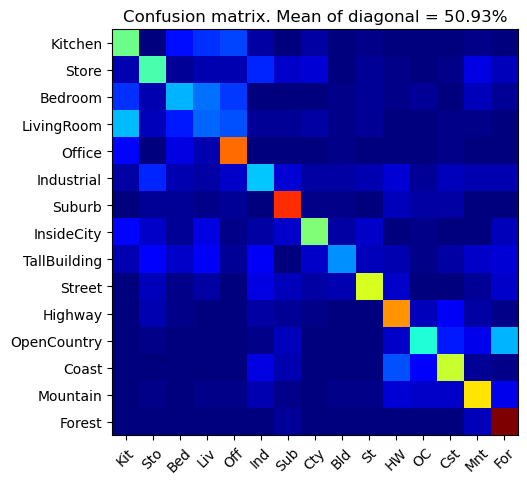

In [49]:
show_results(train_image_paths, test_image_paths, train_labels, test_labels, categories, abbr_categories,
             predicted_categories)



## Section 3: Bag of SIFT features and SVM classifier
We will reuse the bag of SIFT features from Section 2a.

The difference is that this time we will classify them with a support vector machine (SVM).

### Section 3a: Classify each test image by training and using the SVM classifiers

In [50]:
print('Using SVM classifier to predict test set categories')
predicted_categories = sc.svm_classify(train_image_feats, train_labels, test_image_feats,penalty=wandb.config.penalty_svm ,
                                       loss=wandb.config.loss_svm, svm_regular_parameter=wandb.config.regular_parameter_svm)

Using SVM classifier to predict test set categories
['Highway', 'Street', 'Forest', 'InsideCity', 'Bedroom', 'Store', 'Office', 'Coast', 'TallBuilding', 'OpenCountry', 'LivingRoom', 'Suburb', 'Mountain', 'Industrial', 'Kitchen']
current cat : Highway
current cat : Street
current cat : Forest
current cat : InsideCity
current cat : Bedroom
current cat : Store
current cat : Office
current cat : Coast
current cat : TallBuilding
current cat : OpenCountry
current cat : LivingRoom


/home/zly/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zly/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/zly/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


current cat : Suburb
current cat : Mountain
current cat : Industrial
current cat : Kitchen


### Section 3b: Build a confusion matrix and score the recognition system

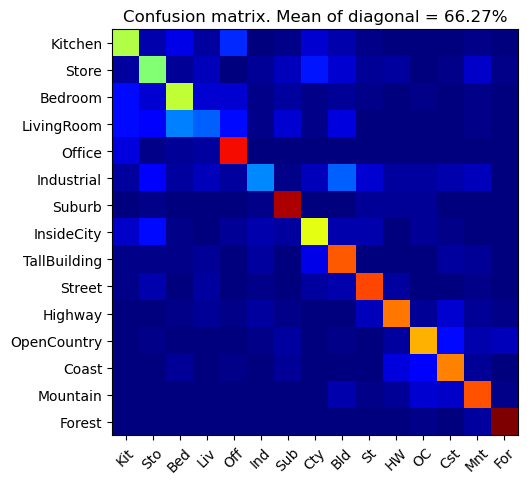

In [51]:
show_results(train_image_paths, test_image_paths, train_labels, test_labels, categories, abbr_categories,
             predicted_categories)